## Hackathon

In [201]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import curve_fit
from functools import partial
from scipy.signal import find_peaks

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [2]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data (handles both time and valid_time safely)."""
        if self.dataset is None:
            raise ValueError("Load data first!")

        subset = self.dataset

        # Determine which time coordinate exists AND is indexable
        if "valid_time" in subset.coords and "valid_time" in subset.dims:
            time_coord = "valid_time"
        elif "time" in subset.coords and "time" in subset.dims:
            time_coord = "time"
        else:
            print("⚠️ Warning: No indexable time coordinate found, skipping time filtering.")
            time_coord = None

        # Apply filters
        if time_coord and time_range:
            subset = subset.sel({time_coord: slice(time_range[0], time_range[1])})
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))

        return subset.compute()



In [ ]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
dataset = loader.load_data()

loader2 = DataLoader("ERA5_wind.nc")
dataset2 = loader2.load_data()

In [ ]:
# Get a subset (May 2023, Europe)
subset = loader.get_subset(
    time_range=("2023-01-01", "2023-12-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)

print(loader)

subset2 = loader2.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(52.0, 53.0),
    lon_range=(4.0, 6.0)
)



In [ ]:
subset_df = subset.to_dataframe().reset_index()
subset_df = subset_df.drop(['number', 'expver'], axis=1)
subset.to_dataframe()

mean_t2m = dataset['t2m'].sel(valid_time=slice("2023-05-01", "2023-05-31")).mean(dim='valid_time')

subset2_df = subset2.to_dataframe().reset_index()
subset2_df = subset2_df.drop(columns=['time', 'number', 'step', 'surface'], errors='ignore')

print(subset2_df.info(), subset_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33480 entries, 0 to 33479
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   latitude    33480 non-null  float64       
 1   longitude   33480 non-null  float64       
 2   valid_time  33480 non-null  datetime64[ns]
 3   u10         33480 non-null  float32       
 4   v10         33480 non-null  float32       
dtypes: datetime64[ns](1), float32(2), float64(2)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   valid_time  8760 non-null   datetime64[ns]
 1   latitude    8760 non-null   float64       
 2   longitude   8760 non-null   float64       
 3   t2m         8760 non-null   float32       
dtypes: datetime64[ns](1), float32(1), float64(2)
memory usage: 239.7 KB
None None


## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [8]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })

    return df

In [9]:
def generate_eval_data_non_rand(lon, lat, start_date=['2023-05-01'], end_date=['2023-05-21']):
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date,
        "end_date": end_date
    })
    return df

In [ ]:
def sine_model(x, A, b, c, d):
    sin = A * np.sin(2*np.pi/c * (x+b)) + d
    return sin

In [ ]:
def ARIMA_sine_fitted(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    
    t = np.arange(len(history))

    guess = [10, 0, 24, np.mean(history)]  
    # limieten: [A1, b1, c1, d1]
    lower = [0, -24, 0, 0]
    upper = [20, 24, 25, 320]

    try:
        params, pcov = curve_fit(sine_model, np.arange(len(history)), history, p0=guess, bounds=(lower, upper))
        A, b, c, d= params

        d -= np.mean(history)
    except:
        A, b, c, d = [0.0, 0.0, 1.0, 0.0]

    y = sine_model(t, A, b, c, d)

    model = sm.tsa.ARIMA(history, order=(1, 0, 0)).fit()

    forecast = model.forecast(steps=n_points)

    x = np.arange(start=len(history), stop=len(history) + n_points)

    forecast_fitted = forecast + sine_model(x, A, b, c, d)

    delta = history[-1] - forecast_fitted[0]

    forecast_fitted += delta

    return forecast_fitted

In [242]:
def ARIMA_sine_fitted_UPDATED(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    
    _3days = 4 * 24
    recent_history = history[-_3days:]

    t = np.arange(len(history))

    guess = [10, 0, 24, np.mean(recent_history)]  
    # limieten: [A1, b1, c1, d1]
    lower = [0, -24, 0, 0]
    upper = [20, 24, 25, 320]

    try:
        params, pcov = curve_fit(sine_model, np.arange(len(recent_history)), recent_history, p0=guess, bounds=(lower, upper))
        A, b, c, d= params

        b += len(history) - len(recent_history)

    except:
        A, b, c, d = [0.0, 0.0, 1.0, 0.0]


    t_total = np.arange(stop=len(history) + n_points)

    x_recent = np.arange(len(history) - _3days, len(history))

    y_fit = sine_model(x_recent, A, b, c, d)

    # Detect only significant peaks
    peaks, _ = find_peaks(recent_history, prominence=2.0)  # tune prominence to your data

    if len(peaks) == 0:
        # fallback: no peak found
        last_peak_idx = np.argmax(recent_history)  # largest value in recent window
    else:
        last_peak_idx = peaks[-1]  # last detected peak

    # Convert local peak index to global index
    x_peak_global = x_recent[last_peak_idx]

    # Now compute b so the sine's peak aligns with this
    b = (c / 4 - x_peak_global) % c  # c is the period from curve_fit

    x = np.arange(start=len(history)-1, stop=len(history) + n_points)

    xy_fit = sine_model(x, A, b, c, d)

        # ---- Plot ----
    # plt.figure(figsize=(10, 5))
    # plt.plot(t, history, label="History", color='blue')
    # plt.plot(x_recent, y_fit, label="Sine Fit", color='orange', linestyle='dashed')
    # plt.plot(x, xy_fit, label="Sine Fit", color='green', linestyle='dashed')
    # plt.plot(x_recent, [np.mean(recent_history)] * len(x_recent), label="Recent Mean", color='green', linestyle='dashed')
    # #plt.scatter(x_peaks, y_peaks)
    # plt.title("History vs. Sine Curve Fit")
    # plt.xlabel("Time")
    # plt.ylabel("Value")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    model = sm.tsa.ARIMA(history, order=(1, 0, 0)).fit()

    forecast = model.forecast(steps=n_points)

    forecast -= forecast.min()

    x = np.arange(start=len(history), stop=len(history) + n_points)

    forecast_fitted = forecast + sine_model(x, A, b, c, d)

    return forecast_fitted

In [ ]:
def AR1(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    mu = np.mean(history)
    sigma = np.std(history)

    X = [history[-1]]

    phi = .9

    for t in range(1, n_points):
        eps = np.random.normal(0, sigma)
        x_t = mu + phi * (X[-1] - mu) + eps * .1

        X.append(x_t)

    return X

In [14]:
def AR1_sine_fitted(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):

    t = np.arange(len(history))

    guess = [10, 0, 24, np.mean(history)]  
    # limieten: [A1, b1, c1, d1]
    lower = [0, -24, 0, 0]
    upper = [20, 24, 25, 320]

    params, pcov = curve_fit(sine_model, np.arange(len(history)), history, p0=guess, bounds=(lower, upper))
    A, b, c, d= params

    d -= np.mean(history)

    y = sine_model(t, A, b, c, d)


    forecast = AR1(history, lon, lat, start_date_hist, end_date_hist)

    x = np.arange(start=len(history), stop=len(history) + n_points)
    forecast_fitted = forecast + sine_model(x, A, b, c, d)

    return forecast_fitted

In [15]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred = function(history, 
                      row['longitude_deg'], 
                      row['latitude_deg'], 
                      row['start_date'],
                      (pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"), 
                      len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
        #ax.plot(range(len(history), len(history) + len(y_true)), y_pred_fitted, color = 'red', linestyle = (0, (1, 1)))
        plt.show()
    return np.mean(np.abs(y_true - y_pred))#, np.abs(y_true - y_pred)#, np.mean(np.abs(y_true - y_pred_fitted))


In [16]:
forecast(np.array([9,8,18]), n_points = 5)

array([18, 18, 18, 18, 18])

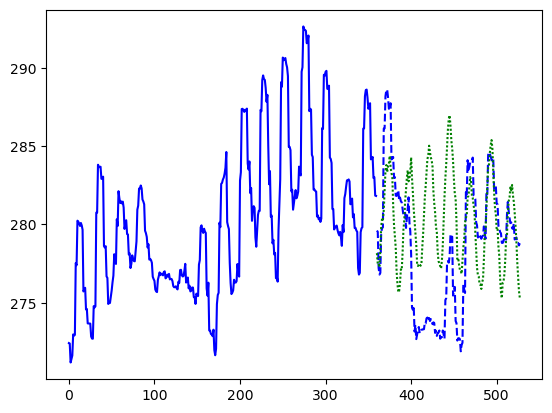

3.886979447085645

In [17]:
#forecast_1w(generate_eval_data(1).iloc[0], forecast, 'manual')
forecast_1w(generate_eval_data(1).iloc[0], AR1_sine_fitted, 'manual')



In [16]:
def evaluator(function, n_samples = 100):
    errors = []
    #errors_fitted = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error= forecast_1w(row, function, operation = 'loop')
        errors.append(error)
    return np.mean(errors)

In [243]:
time_avg = 1000.0 / 124.6
n = 1000

print('time to calculate: ' + str(round(((n / time_avg) / 60), 1)) + ' minutes')

evaluator(ARIMA_sine_fitted_UPDATED, n)

time to calculate: 2.1 minutes


e:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

e:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

e:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



2.4742812371691087

In [ ]:
error_df_ARIMA_UPDATED = pd.DataFrame(columns=['lon', 'lat', 'error'])

high_error = []

for lat in range(3400, 7150, 100):
    for lon in range(-2500, 3750, 100):
        df = generate_eval_data_non_rand(lon / 100, lat/ 100)
        error= forecast_1w(df.iloc[0], ARIMA_sine_fitted_UPDATED, operation = 'loop')
        error_df_ARIMA_UPDATED.loc[len(error_df_ARIMA_UPDATED)] = [lon / 100, lat / 100, error]

        if np.mean(error) > 7.0:
            lon_lat = [lon / 100, lat / 100]
            high_error.append(lon_lat)

e:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

e:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

e:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

e:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

e:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

e:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

e:\Anaconda\Lib\site-packa

In [234]:
error_df_ARIMA_UPDATED['error'].mean()

2.4113240679329206

In [17]:
error_df = pd.read_csv('ARIMA_UPDATED_error.csv', index_col='Unnamed: 0')

error_df.head()

,lon,lat,error
0,-25.00,34.0,0.411730
1,-24.75,34.0,0.393578
2,-24.50,34.0,0.395747
3,-24.25,34.0,0.407464
4,-24.00,34.0,0.496146


In [23]:
# Merge on lon/lat (inner join ensures only overlapping coords are kept)
merged = pd.merge(
    error_df,
    error_df_ARIMA_UPDATED,
    on=['lon', 'lat'],
    suffixes=('_old', '_new')
)

# Compute absolute difference
merged['error_diff'] = (merged['error_new'] - merged['error_old'])#.abs()

# Optional: keep only lon, lat, and diff
error_diff_df = merged[['lon', 'lat', 'error_diff']]

print(error_diff_df.head())


NameError: name 'error_df_ARIMA_UPDATED' is not defined

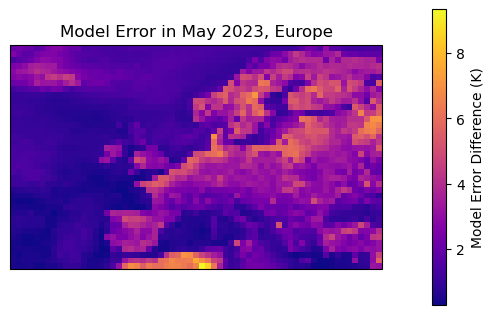

In [219]:
# Vind unieke waarden
lons = np.sort(error_df_ARIMA_UPDATED['lon'].unique())
lats = np.sort(error_df_ARIMA_UPDATED['lat'].unique())

# Reshape error naar 2D-array
error_grid = error_df_ARIMA_UPDATED['error'].values.reshape(len(lats), len(lons))


# Maak meshgrid
LON, LAT = np.meshgrid(lons, lats)

# Plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Inverted cmap + manual scale
#vmin, vmax = 0.21303982325127824, 9.697968226707493  # 👈 adjust manually as needed
pcm = ax.pcolormesh(
    LON,
    LAT,
    error_grid,
    cmap='plasma',
    shading='auto' \
    '',
    # vmin=vmin,
    # vmax=vmax
)

# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.COASTLINE)

# GEEN gridlines: verwijder ax.gridlines entirely

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Model Error Difference (K)')

ax.set_title('Model Error in May 2023, Europe')
plt.savefig('errors_diff.png', dpi=300)
plt.show()

# print(error_df_ARIMA_UPDATED['error'].mean())
# print(error_df_ARIMA_UPDATED['error'].median())
# print(error_df_ARIMA_UPDATED['error'].std())
# print(error_df_ARIMA_UPDATED['error'].max())
# print(error_df_ARIMA_UPDATED['error'].min())
# plt.hist(error_df['error'], label='old', bins=50)
# plt.hist(error_df_ARIMA_UPDATED['error'], label='new', bins=50)

# print('\n')

# print(error_df['error'].mean())
# print(error_df['error'].median())
# print(error_df['error'].std())
# print(error_df['error'].max())
# print(error_df['error'].min())


# plt.legend()
# plt.show()

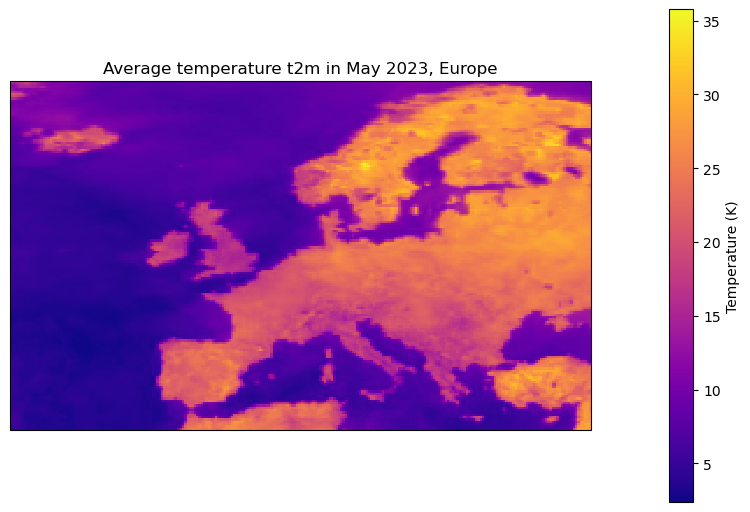

In [19]:
# Task 1
lats = np.linspace(34, 71.25, 150)
lons = np.linspace(-25, 37.25, 250)

LON, LAT = np.meshgrid(lons, lats)

t2m_values = loader.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(34, 71.25),
    lon_range=(-25, 37.25)
)

monthly_mean = t2m_values['t2m'].max(dim='valid_time').values - t2m_values['t2m'].min(dim='valid_time').values

coords = np.stack([LAT, LON], axis=-1)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

pcm = ax.pcolormesh(
    LON, LAT, monthly_mean,
    cmap='plasma',
    shading='auto'
)

# Add country borders
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.COASTLINE)

# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Temperature (K)')

ax.set_title('Average temperature t2m in May 2023, Europe')
plt.savefig('temp_differences.png', dpi=1000)
plt.show()


In [ ]:
def normalize_centered(arr):
    max_val = np.max(np.abs(arr))
    return (arr / (2 * max_val + 1e-8)) + 0.5

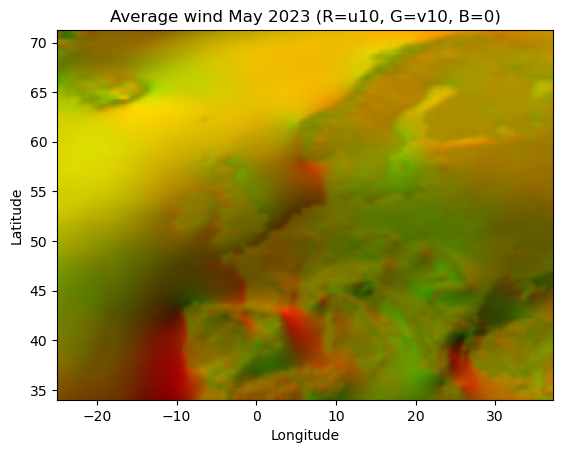

In [ ]:
# --- Coordinates ---
lats = np.linspace(34, 71.25, 150)
lons = np.linspace(-25, 37.25, 250)
LON, LAT = np.meshgrid(lons, lats)

# --- Load subset ---
t2m_values = loader2.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(34, 71.25),
    lon_range=(-25, 37.25)
)

# --- Compute mean wind ---
u_mean = t2m_values['u10'].mean(dim='time').values
v_mean = t2m_values['v10'].mean(dim='time').values

# --- Normalize around 0 for correct colors ---
def normalize_centered(arr):
    max_val = np.max(np.abs(arr))
    return (arr / (2*max_val + 1e-8)) + 0.5

r = normalize_centered(u_mean)
g = normalize_centered(v_mean)
b = np.zeros_like(r)

rgb = np.stack([r, g, b], axis=-1)

# --- Plot with imshow ---
fig, ax = plt.subplots()

# extent = [xmin, xmax, ymin, ymax] in real coordinates
extent = [lons.min(), lons.max(), lats.min(), lats.max()]
ax.imshow(rgb, origin='lower', extent=extent, aspect='auto')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Average wind May 2023 (R=u10, G=v10, B=0)")

plt.savefig('wind.png', dpi=1000)
plt.show()



6.784143448073256 363.9319804030601 24.38425444822442 289.8147480098652


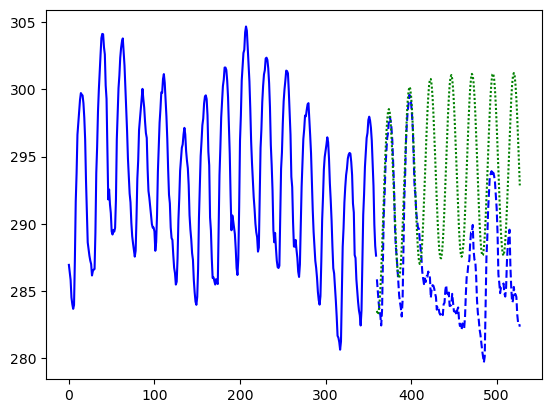

6.625148326359825


In [102]:
rows = error_df.sort_values(ascending=False, by='error')[:1]

errors = []

# Sorteer top 5 errors
#rows = error_df.sort_values(by='error', ascending=False).head(5)

for _, row in rows.iterrows():
    lon = row['lon']
    lat = row['lat']

    # Genereer data en forecast
    df = generate_eval_data_non_rand(lon, lat).reset_index()
    df = df.set_index('index')
    error = forecast_1w(df.iloc[0], ARIMA_sine_fitted_UPDATED, operation='manual')
    errors.append(error)

    sample_temp = loader.get_subset(
    time_range=(df['start_date'].iloc[0], df['end_date'].iloc[0]),
    lat_range=(df['latitude_deg'].iloc[0], df['latitude_deg'].iloc[0]),
    lon_range=(df['longitude_deg'].iloc[0], df['longitude_deg'].iloc[0])
    ).compute()

    history_temp = sample_temp.sel(valid_time=slice(df['start_date'].iloc[0],(pd.to_datetime(df['start_date'].iloc[0]) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true_temp = sample_temp.sel(valid_time=slice((pd.to_datetime(df['start_date'].iloc[0]) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),df['end_date'].iloc[0]))['t2m'].data.flatten()

    total_temp = total_wind = np.concatenate((history_temp, y_true_temp))

    sample_wind = loader2.get_subset(
    time_range=(df['start_date'].iloc[0], df['end_date'].iloc[0]),
    lat_range=(df['latitude_deg'].iloc[0], df['latitude_deg'].iloc[0]),
    lon_range=(df['longitude_deg'].iloc[0], df['longitude_deg'].iloc[0])
    ).compute()

    history_wind = sample_wind.sel(time=slice(df['start_date'].iloc[0],(pd.to_datetime(df['start_date'].iloc[0]) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['u10'].data.flatten()
    y_true_wind = sample_wind.sel(time=slice((pd.to_datetime(df['start_date'].iloc[0]) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),df['end_date'].iloc[0]))['u10'].data.flatten()

    total_wind = np.concatenate((history_wind, y_true_wind))


#     fig, ax1 = plt.subplots()

#     # Left Y-axis (temperature)
#     ax1.plot(range(len(history_temp)), history_temp, color='blue', label='Temperature')
#     ax1.plot(range(len(history_temp), len(history_temp) + len(y_true_temp)), y_true_temp, 
#             color='blue', linestyle='dashed')
#     ax1.set_ylabel('Temperature (t2m)', color='blue')
#     ax1.tick_params(axis='y', labelcolor='blue')

#     # Right Y-axis (wind)
#     ax2 = ax1.twinx()
#     ax2.plot(range(len(history_wind)), history_wind, color='red', label='Wind speed')
#     ax2.plot(range(len(history_wind), len(history_wind) + len(y_true_wind)), y_true_wind, 
#             color='red', linestyle='dashed')
#     ax2.set_ylabel('Wind (u10)', color='red')
#     ax2.tick_params(axis='y', labelcolor='red')

#     # Common X label and show
#     ax1.set_xlabel('Time steps')
#     fig.tight_layout()
#     plt.show()

    #print(np.corrcoef(total_temp, total_wind))

print(np.mean(errors))


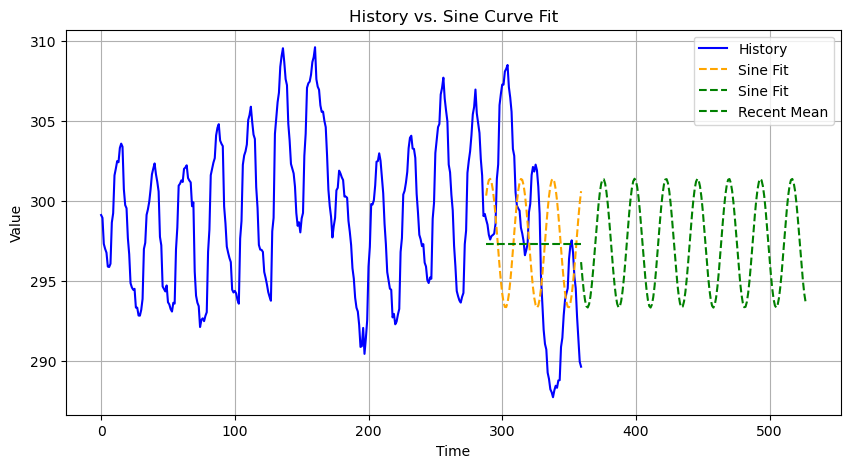

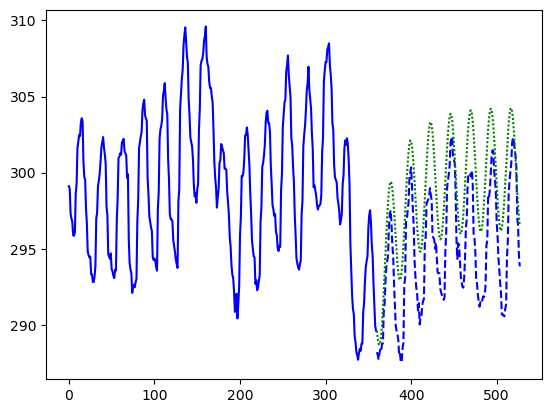

3.778010076784952 34.0 7.0


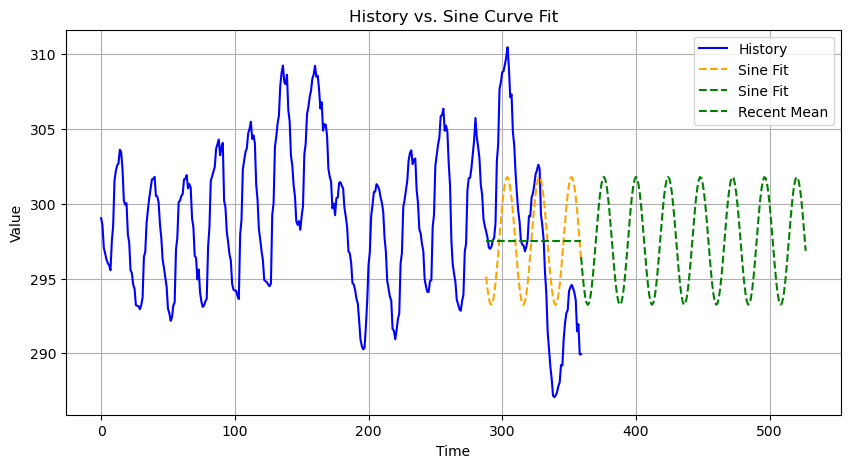

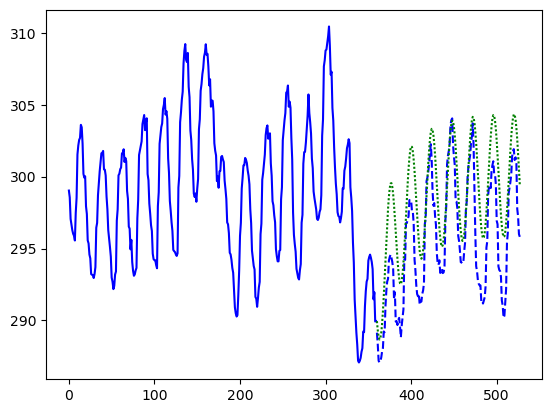

3.0951232986707744 34.0 8.0


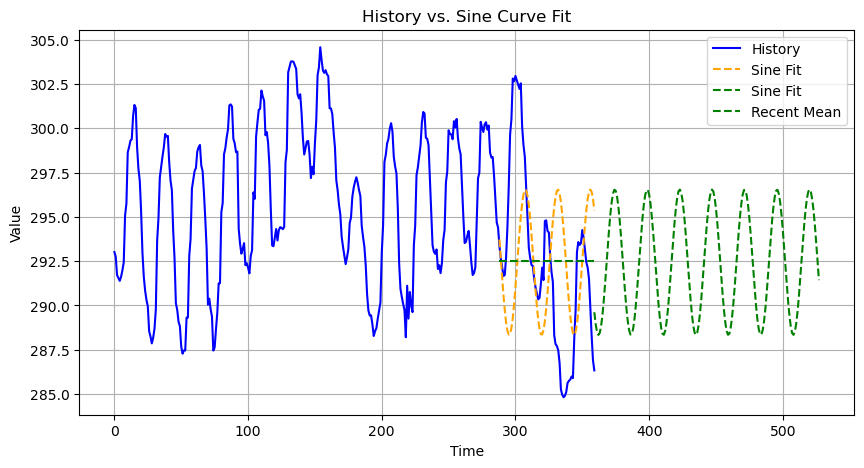

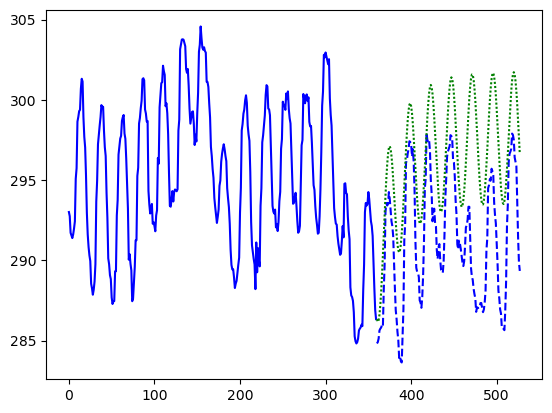

4.986019152379377 35.0 6.0


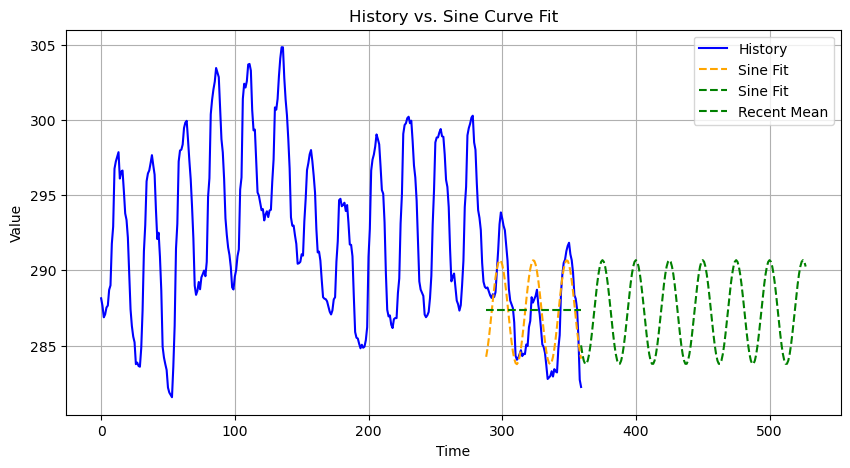

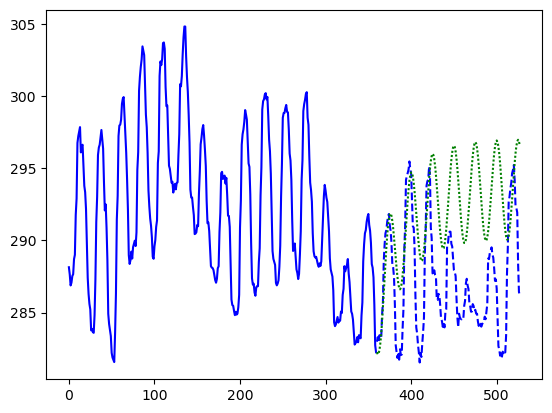

5.339181800699011 36.0 4.0


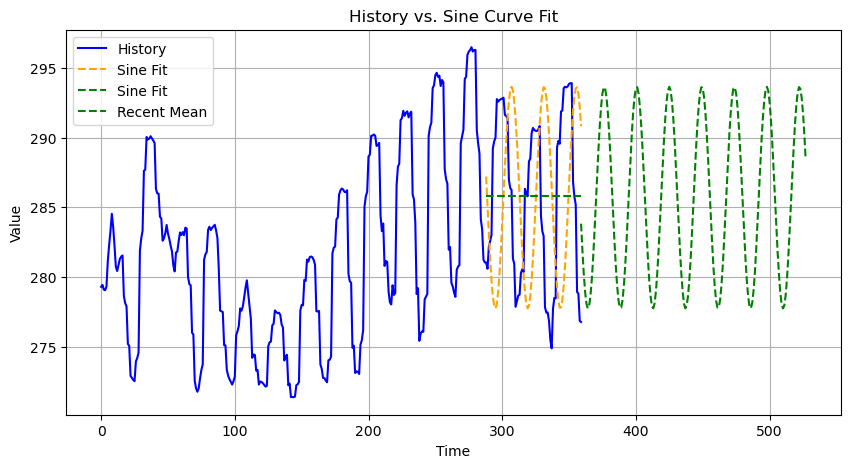

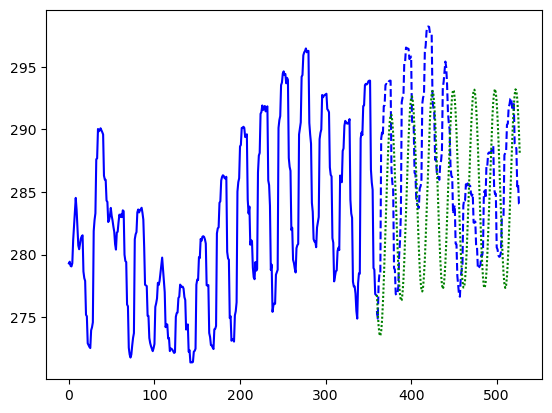

6.872829820828069 59.0 37.0


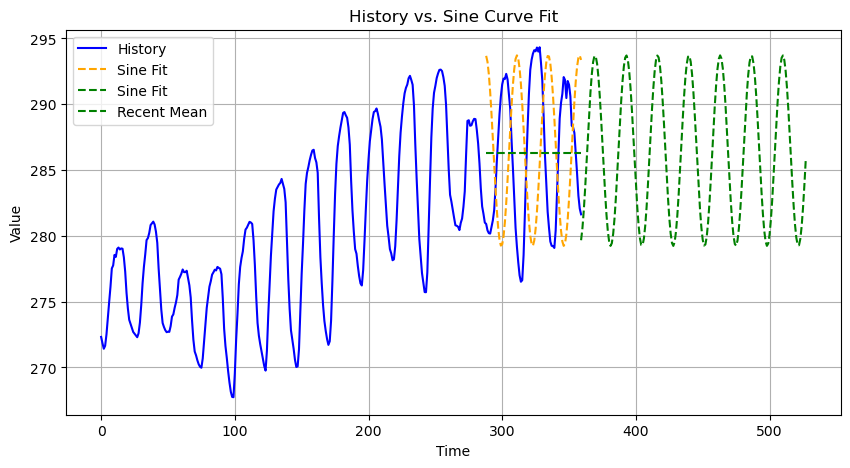

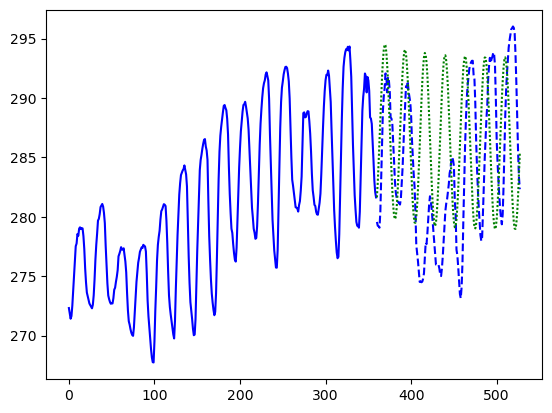

7.0067068138586315 63.0 16.0


In [230]:

lon = 30.0
lat = 50

lonlats = [[30.0, 50.0], [-16.0, 65.0], [-5.0, 35.0], [-25.0, 34.0], [4.5, 36.0], [-6.0, 34.0]]

total_error = []

for lon, lat in high_error:

    errors = []

    # Genereer data en forecast
    df = generate_eval_data_non_rand(lon, lat).reset_index()
    df = df.set_index('index')
    error = forecast_1w(df.iloc[0], ARIMA_sine_fitted_UPDATED, operation='manual')
    errors.append(error)

    sample_temp = loader.get_subset(
    time_range=(df['start_date'].iloc[0], df['end_date'].iloc[0]),
    lat_range=(df['latitude_deg'].iloc[0], df['latitude_deg'].iloc[0]),
    lon_range=(df['longitude_deg'].iloc[0], df['longitude_deg'].iloc[0])
    ).compute()

    print(np.mean(errors), lat, lon)
    total_error.append(np.mean(errors))

#print(np.mean(total_error))